In [1]:
import os
import sys

# Add the project's root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import argparse
import random
import time
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import copy
import torchvision
import warnings


from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.optimizer import Optimizer, required
from torch.optim.lr_scheduler import StepLR

%matplotlib inline

warnings.filterwarnings('ignore')

## Install R package BayesGPfit

from GP_comp.GP import gp_eigen_value, gp_eigen_funcs_fast, generate_grids

## 1. Model

### 1.1  BNNSTGP

In [2]:
## BNNSTGP Model

class BNNSTGP_one_layer(nn.Module):
    def __init__(self, input_dim, n_hid, output_dim, w_dim, n_knots, phi, lamb=1.,
                 b_prior_sig=1, zeta_prior_sig=1, eta_prior_sig=1, alpha_prior_sig=1,
                 act='relu'):
        super(BNNSTGP_one_layer, self).__init__()

        self.input_dim = input_dim
        self.n_hid = n_hid
        self.output_dim = output_dim
        self.w_dim = w_dim
        self.n_knots = n_knots
        self.phi = phi
        self.lamb = lamb

        self.sigma = nn.Parameter(torch.tensor(1.))
        self.b = nn.Parameter(torch.Tensor(n_knots, n_hid).normal_(0, 1))
        self.zeta = nn.Parameter(torch.Tensor(n_hid, output_dim).uniform_(-1, 1))
        self.eta = nn.Parameter(torch.Tensor(n_hid).zero_())
        self.alpha = nn.Parameter(torch.Tensor(w_dim, output_dim).zero_())

        self.b_prior_sig = b_prior_sig
        self.zeta_prior_sig = zeta_prior_sig
        self.eta_prior_sig = eta_prior_sig
        self.alpha_prior_sig = alpha_prior_sig

        if act == 'relu':
            self.act = torch.relu
        elif act == 'tanh':
            self.act = torch.tanh
        elif act == 'sigmoid':
            self.act = torch.sigmoid
        else:
            raise ValueError('Invalid activation function %s' % act)

    def forward(self, x, w):
        out = torch.mm(self.phi, self.b)
        out = F.threshold(out, self.lamb, self.lamb) - F.threshold(-out, self.lamb, self.lamb)
        out = self.sigma * out
        out = torch.mm(x, out) + self.eta

        out = self.act(out)
        out = torch.mm(out, self.zeta)

        return out

    def log_prior(self):
        logprior = 0.5 * (self.b ** 2).sum() / (self.b_prior_sig ** 2)
        logprior += 0.5 * (self.zeta ** 2).sum() / (self.zeta_prior_sig ** 2)
        logprior += 0.5 * (self.eta ** 2).sum() / (self.eta_prior_sig ** 2)
        logprior += 0.5 * (self.alpha ** 2).sum() / (self.alpha_prior_sig ** 2)
        return logprior




### 1.2 SGLD 

In [3]:


## SGLD (Stochastic Gradient Langevin Dynamics)

class SGLD(Optimizer):
    def __init__(self, params, lr = required, langevin = True):
        self.langevin = langevin
        defaults = dict(lr=lr)
        super(SGLD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        loss = None
        
        for group in self.param_groups:
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                
                if self.langevin == True:
                    langevin_noise = p.new(p.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.add_(0.5*d_p + langevin_noise, alpha = -group['lr'])

                else:
                    p.add_(0.5*d_p, alpha = -group['lr'])


        return loss


### 1.3 Network Wrapper

In [4]:

## Network Wrapper

class Net(object):

    def __init__(self, task='binary', lr=1e-3, input_dim=784, n_hid = 128, output_dim = 1, w_dim = 1, n_knots = 66,
                 N_train=200, phi=None, lamb = 1, langevin = True, step_decay_epoch = 100, step_gamma = 0.1, act = 'relu'):
        
        #print(' Creating Net!! ')
        self.task = task
        if task not in ['binary', 'multiclass', 'regression']:
            raise ValueError('Invalid task %s' % task)
        self.lr = lr

        self.input_dim = input_dim
        self.n_hid = n_hid
        self.output_dim = output_dim
        self.w_dim = w_dim
        self.n_knots = n_knots
        self.phi = phi
        self.lamb = lamb
        self.act = act

        self.N_train = N_train
        self.langevin = langevin
        self.step_decay_epoch = step_decay_epoch
        self.step_gamma = step_gamma

        self.create_net()
        self.create_opt()
        self.epoch = 0
        
        self.weight_set_samples = []


    def create_net(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = BNNSTGP_one_layer(input_dim=self.input_dim, n_hid=self.n_hid, output_dim=self.output_dim, 
                            w_dim=self.w_dim, n_knots = self.n_knots, phi=torch.tensor(self.phi).to(self.device),
                            lamb = self.lamb, act = self.act)
        self.model.to(self.device)


    def create_opt(self):
        self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, langevin = self.langevin)
        self.scheduler = StepLR(self.optimizer, step_size = self.step_decay_epoch, gamma=self.step_gamma)


    def fit(self, x, w, y, threshold=0.5):
        x = x.to(self.device)
        w = w.to(self.device)

        if self.task == 'binary':
            y = y.float().to(self.device).reshape(-1, 1)
            self.optimizer.zero_grad()

            out = self.model(x, w)
            loss = F.binary_cross_entropy_with_logits(out, y, reduction='mean')
            loss = loss * self.N_train 
            #loss += self.model.log_prior()
            
            loss.backward()
            self.optimizer.step() 

            pred = (torch.sigmoid(out)>threshold).long()
            accu = (pred == y.long()).sum().float()
        elif self.task == 'regression':
            y = y.float().to(self.device).reshape(-1, 1)
            self.optimizer.zero_grad()

            out = self.model(x, w)
            loss = F.mse_loss(out, y, reduction='mean')
            loss = loss * self.N_train 
            loss += self.model.log_prior()
            
            loss.backward()
            self.optimizer.step() 

            pred = 0.0
            accu = 0.0

        else:                           ## multiclass
            y = y.long().to(self.device).reshape(-1)
            self.optimizer.zero_grad()

            out = self.model(x, w)
            loss = F.cross_entropy(out, y, reduction = 'mean')
            loss = loss * self.N_train 
            loss += self.model.log_prior()
            
            loss.backward()
            self.optimizer.step()

            pred = out.max(dim=1, keepdim=False)[1]
            accu = (pred == y).sum()

        return loss*x.shape[0]/self.N_train, accu

    
    def eval(self, x, w, y, threshold=0.5):
        x = x.to(self.device)
        w = w.to(self.device)
        
        if self.task == 'binary':
            y = y.float().to(self.device).reshape(-1, 1)

            out = self.model(x, w)
            loss = F.binary_cross_entropy_with_logits(out, y, reduction='mean') 
            loss = loss * self.N_train 
            loss += self.model.log_prior()

            pred = (torch.sigmoid(out)>threshold).float() 
            accu = (pred == y).sum().float()
        elif self.task == 'regression':
            y = y.float().to(self.device).reshape(-1, 1)

            out = self.model(x, w)
            loss = F.mse_loss(out, y, reduction='mean') 
            loss = loss * self.N_train 
            loss += self.model.log_prior()

            pred = 0.0
            accu = 0.0

        else:                        ## multiclass
            y = y.long().to(self.device).reshape(-1)

            out = self.model(x, w)
            loss = F.cross_entropy(out, y, reduction = 'mean')
            loss = loss * self.N_train 
            loss += self.model.log_prior()

            pred = out.max(dim=1, keepdim=False)[1]
            accu = (pred == y).sum()

        return loss*x.shape[0]/self.N_train, accu
    

    def get_nb_parameters(self):
        return sum(p.numel() for p in self.model.parameters())


    def save_net_weights(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        #print(' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )


    def all_sample_eval(self, x, w, y, threshold=0.5):    
        x = x.to(self.device)
        w = w.to(self.device)
        y = y.float().to(self.device)
        
        pred = x.new(len(self.weight_set_samples), x.shape[0], self.output_dim)
        
        for i, weight_dict in enumerate(self.weight_set_samples):
            self.model.load_state_dict(weight_dict)
            out_i = self.model(x, w)
            pred[i] = torch.sigmoid(out_i)
            
        pred = (pred.mean(0)>threshold).float()
        accu = (pred == y).sum().float()

        return accu


    def save(self, filename):
        print('Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer,
            'scheduler': self.scheduler}, filename)

    def load(self, filename):
        print('Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        self.scheduler = state_dict['scheduler']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


## 2. Load sythntic Data by Guoxuan

Simulated 20000 images of 100×100 = 10000 pixels true_sigma2=0.0


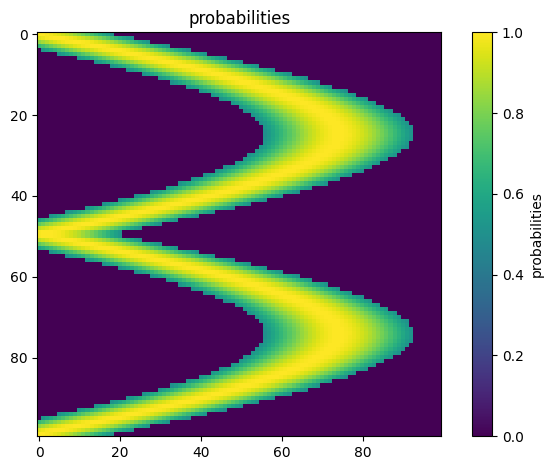

In [5]:
from simulate_single_modality import simulate_data
from utils import generate_linear_data, plot_mse, plot_sigma_squared, calculate_p_hat, plot_image
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset
# Step 2: Generate synthetic data
# simulate a batch of images
in_feature = 100
r2 = 1.0                  # signal-to-noise ratio
n = 20000                  # number of images/samples
grids, true_beta, img, Y, true_sigma2 = simulate_data(n=n, r2=r2, dim=in_feature, random_seed=42)
# torch tensors

# pick one of your simulated images
print(f"Simulated {n} images of {in_feature}×{in_feature} = {img.shape[1]} pixels true_sigma2={true_sigma2}")
plot_image(true_beta)

X = torch.from_numpy(img).float().to('cpu')    # X.shape= (number of rows, total number of vexels)
y = torch.from_numpy(Y).float().to('cpu')      # y.shape= (number of rows,)

class mydata(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    def __len__(self):
        return len(self.y_list)
    def __getitem__(self, i):
        x = self.x_list[i].reshape(-1)
        w = torch.tensor([1.])
        y = torch.tensor([self.y_list[i]])
        return (x, w), y

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset

def create_dataloaders(X, y, val_ratio=0.2, batch_size=32, shuffle=True):
    """
    Splits X, y into training and validation DataLoaders.
    
    Args:
        X (torch.Tensor): Feature tensor, shape (n_samples, n_features).
        y (torch.Tensor): Target tensor, shape (n_samples,).
        val_ratio (float): Proportion of dataset to use for validation (default=0.2).
        batch_size (int): Batch size for DataLoader (default=32).
        shuffle (bool): Whether to shuffle the dataset before splitting (default=True).
    
    Returns:
        train_loader (DataLoader), val_loader (DataLoader)
    """
    # Wrap tensors into a TensorDataset
    dataset = mydata(X, y)
    
    # Calculate sizes
    n_samples = len(dataset)
    n_val = int(n_samples * val_ratio)
    n_train = n_samples - n_val
    
    # Random split
    train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, n_train, n_val
train_loader, val_loader, n_train, n_test = create_dataloaders(X, y, val_ratio=0.2, batch_size=64)


## 3. Training using full data

In [7]:
def MNIST_all(train_loader, val_loader, n_epochs = 10000, lr = 1e-5, b = 10, lamb = 2.5, langevin = True, seed = 17, act = 'relu'):
    grids = generate_grids(dimensions=2, num_grids=in_feature)
    phi = gp_eigen_funcs_fast(grids, b = b, poly_degree = 20)
    phi = np.array(phi)

    torch.set_default_dtype(torch.float32)

    net = Net(lr=lr, input_dim=in_feature*in_feature, n_hid = 8, output_dim = 1, w_dim = 1, n_knots = phi.shape[1],
            N_train=2*n, phi=torch.tensor(phi, dtype=torch.float32), lamb = lamb, langevin=langevin,
            step_decay_epoch = 2000, step_gamma = 0.2, act = act, task='regression')
    

    epoch = 0

    start_save = 3 * n_epochs / 4
    save_every = 2
    N_saves = 100
    test_every = 20
    print_every = 100

    loss_train = np.zeros(n_epochs)
    accu_train = np.zeros(n_epochs)

    loss_val = np.zeros(n_epochs)
    accu_val = np.zeros(n_epochs)

    best_accu = 0

    for i in range(epoch, n_epochs):

        tic = time.time()
        net.scheduler.step()
        
        for (x, w), y in train_loader:
            loss, accu = net.fit(x, w, y)
            loss_train[i] += loss
            accu_train[i] += accu

            
        loss_train[i] /= n_train
        accu_train[i] /= n_train
        toc = time.time()

        if i > start_save and i % save_every == 0:
            net.save_net_weights(max_samples = N_saves)

        
        if i % test_every == 0:
            with torch.no_grad():
                tic = time.time()
                for (x, w), y in val_loader:
                    loss, accu = net.eval(x, w, y)

                    loss_val[i] += loss
                    accu_val[i] += accu

                loss_val[i] /= n_test
                accu_val[i] /= n_test
                toc = time.time()
                best_accu = max(best_accu, accu_val[i])
            
            if i % print_every == 0:
                print('Epoch %d, train accuracy %.2f%%, loss_train=%s' % (i, accu_train[i]*100, loss_train[i]))
                print('Epoch %d, test accuracy %.2f%%, loss_val=%s' % (i, accu_val[i]*100, loss_val[i]))
        
    return net

In [8]:
net = MNIST_all(train_loader, val_loader, n_epochs = 400, lr = 5e-7, b = 20, lamb = 2.5, langevin = True, act = 'relu')

Epoch 0, train accuracy 0.00%, loss_train=3.504748779296875
Epoch 0, test accuracy 0.00%, loss_val=1.876533935546875
Epoch 100, train accuracy 0.00%, loss_train=0.059601600646972654
Epoch 100, test accuracy 0.00%, loss_val=0.051820343017578124
Epoch 200, train accuracy 0.00%, loss_train=0.03174210929870606
Epoch 200, test accuracy 0.00%, loss_val=0.029955997467041015
Epoch 300, train accuracy 0.00%, loss_train=0.02757514762878418
Epoch 300, test accuracy 0.00%, loss_val=0.02749350929260254


In [9]:
betas= []
for j, weight_dict in enumerate(net.weight_set_samples):
    net.model.load_state_dict(weight_dict)
    tmp = torch.mm(net.model.phi, net.model.b)
    tmp = F.threshold(tmp, net.model.lamb, net.model.lamb) - F.threshold(-tmp, net.model.lamb, net.model.lamb)
    tmp = net.model.sigma * tmp
    beta = tmp.cpu().detach().numpy()
    betas.append(beta)

In [17]:
beta_arr = np.stack(betas, axis=0)
mask = (beta_arr < -0.001) | (beta_arr > 0.001)
any_nz = np.any(mask, axis=2).astype(int)
p_hat = any_nz.astype(float).mean(axis=0)

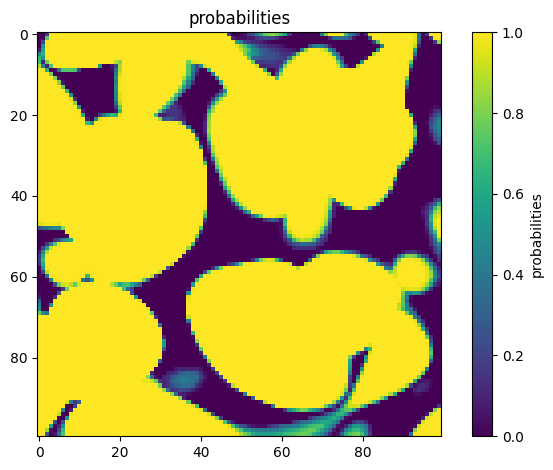

In [18]:
plot_image(p_hat)